In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw
from skimage.measure import label, regionprops, regionprops_table
from tqdm.notebook import tqdm

In [2]:
rename_dict = {v:k for k, v in {"area": "area(mm2)", 
                                "convex_area": "convex_area(mm2)", 
                                "equivalent_diameter": "equivalent_diameter(mm)", 
                                "major_axis_length": "major_axis_length(mm)",
                                "minor_axis_length": "minor_axis_length(mm)", 
                                "min_area_rect_max": "min_area_rect_max(mm)", 
                                "min_area_rect_min": "min_area_rect_min(mm)", 
                                "perimeter": "perimeter(mm)"}.items()}
rename_dict

{'area(mm2)': 'area',
 'convex_area(mm2)': 'convex_area',
 'equivalent_diameter(mm)': 'equivalent_diameter',
 'major_axis_length(mm)': 'major_axis_length',
 'minor_axis_length(mm)': 'minor_axis_length',
 'min_area_rect_max(mm)': 'min_area_rect_max',
 'min_area_rect_min(mm)': 'min_area_rect_min',
 'perimeter(mm)': 'perimeter'}

In [3]:
# read uav measured data
merged_pd20 = pd.read_excel("../03_data_ana/out/2020_measured_fix.xlsx")
merged_pd20 = merged_pd20.rename(columns=rename_dict)

merged_pd21 = pd.read_excel("../03_data_ana/out/2021_measured_fix.xlsx")
merged_pd21 = merged_pd21.rename(columns=rename_dict)
merged_pd21.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_pd21 = merged_pd21.dropna()

In [4]:
# read field measured data
non_destructive20 = pd.read_csv("out/non_destructive20.csv")
non_destructive21 = pd.read_csv("out/non_destructive_manual.csv")

# polygon shape based compare

![](https://img.sigmameow.com/picgo/jupyter_20210727195124.png)

In [5]:
def draw_binary_image(poly_list):
    poly_merge = np.vstack(poly_list)
    
    xmax, ymax = np.max(poly_merge, axis=0)
    xmin, ymin = np.min(poly_merge, axis=0)
    xlen = xmax - xmin
    ylen = ymax - ymin

    res = 0.1 # 1mm/ pix
    
    w = xlen / res
    h = ylen / res

    im = Image.new(mode='1', size=tuple(np.ceil([w, h]).astype(int)))
    draw = ImageDraw.Draw(im)
    
    for p in poly_list:
        points = (p - np.asarray([xmin, ymin])) / res
        draw.polygon(points.reshape(len(points)*2).tolist(), fill='white', outline='white')
        
    return np.asarray(im)

In [6]:
props_all = pd.DataFrame(columns=["date", "field", "area", "convex_area", "eccentricity", "equivalent_diameter", "major_axis_length", "minor_axis_length", "perimeter", 'circularity'])

for index, row in tqdm(non_destructive21.iterrows()):
    a = np.asarray([0, row["0"] /2])
    b = np.asarray([row["45"]/2/np.sqrt(2), row["45"]/2/np.sqrt(2)])
    c = np.asarray([row["90"]/2, 0])
    d = np.asarray([row["135"]/2/np.sqrt(2), -row["135"]/2/np.sqrt(2)])
    e = -a
    f = -b
    g = -c
    h = -d
    poly = np.asarray([a,b,c,d,e,f,g,h,a])
    
    binary_img = draw_binary_image([poly])
    
    label_img = label(binary_img)
    
    props = pd.DataFrame(regionprops_table(label_img, properties=['label', "area", "convex_area", "eccentricity", "equivalent_diameter", "major_axis_length", "minor_axis_length", "perimeter"]))
    props['circularity'] = 4 * props.area * np.pi / props.perimeter ** 2
    
    props['date'] = row["date"]
    props['field'] = row["field"]
    props = props[["date", "field", "area", "convex_area", "eccentricity", "equivalent_diameter", "major_axis_length", "minor_axis_length", "perimeter", 'circularity']]

    props_all.loc[len(props_all)] = props.iloc[0]

0it [00:00, ?it/s]

In [7]:
props_all["min_area_rect_max"] = non_destructive21[["0", "45", "90", "135"]].max(axis=1)

from matplotlib.collections import PolyCollection
import seaborn as sns
import matplotlib.patheffects as pe# draw figures

In [8]:
from matplotlib.collections import PolyCollection
import seaborn as sns
import matplotlib.patheffects as pe

In [9]:
USMALL_SIZE = 12
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

cm = 1/2.54

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [10]:
match_date20 = [20200522, 20200526, 20200528]
match_date21 = [20210512, 20210515, 20210519, 20210520, 20210526]

In [11]:
palette20 = sns.color_palette("Spectral", n_colors=5)
palette20.remove(palette20[2])
palette20.remove(palette20[2])
palette20

[(0.9139561707035756, 0.36239907727797, 0.27935409457900806),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.3280276816608997, 0.6805074971164936, 0.6802768166089965)]

In [12]:
palette21 = sns.color_palette("Spectral", n_colors=7)
palette21.remove(palette21[2])
palette21.remove(palette21[2])
palette21

[(0.8662821991541715, 0.2901191849288735, 0.2978085351787774),
 (0.9748558246828143, 0.5574009996155325, 0.32272202998846594),
 (0.8384467512495197, 0.9349480968858133, 0.6089965397923875),
 (0.5273356401384084, 0.8106113033448674, 0.6452133794694349),
 (0.24006151480199925, 0.58239138792772, 0.7208765859284891)]

In [13]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

In [14]:
def lowess(x, y, frac=0.5):
    lowess = sm.nonparametric.lowess
    z = lowess(y, x, frac)
    x_points = []
    y_points = []
    for x_y in z:
        x_points.append(x_y[0])
        y_points.append(x_y[1])
    return x_points, y_points

def linear(x, y, printf=True):
    def func(x, a, b):
        y = a * x + b
        return y

    def fitans(xdata, ydata):
        popt, pcov = curve_fit(func, xdata, ydata)
        residuals = ydata - func(xdata, *popt)
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        return popt, pcov, r_squared
    
    t, p, r2 = fitans(x, y)
    
    x_points = np.linspace(min(x), max(x), num=max(int(max(x)-min(x))+1, 100), endpoint=True)
    y_points = func(x_points, *t)
    y_predict = func(x, *t)
    if printf:
        print(f'y={round(t[0], 3)}x+{round(t[1], 3)}  R^2={round(r2, 2)}')
        print(f'RMSE = {rmse(y_predict, y)}')
        print('-----------------')
    return x_points, y_points, y_predict, t, r2

def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

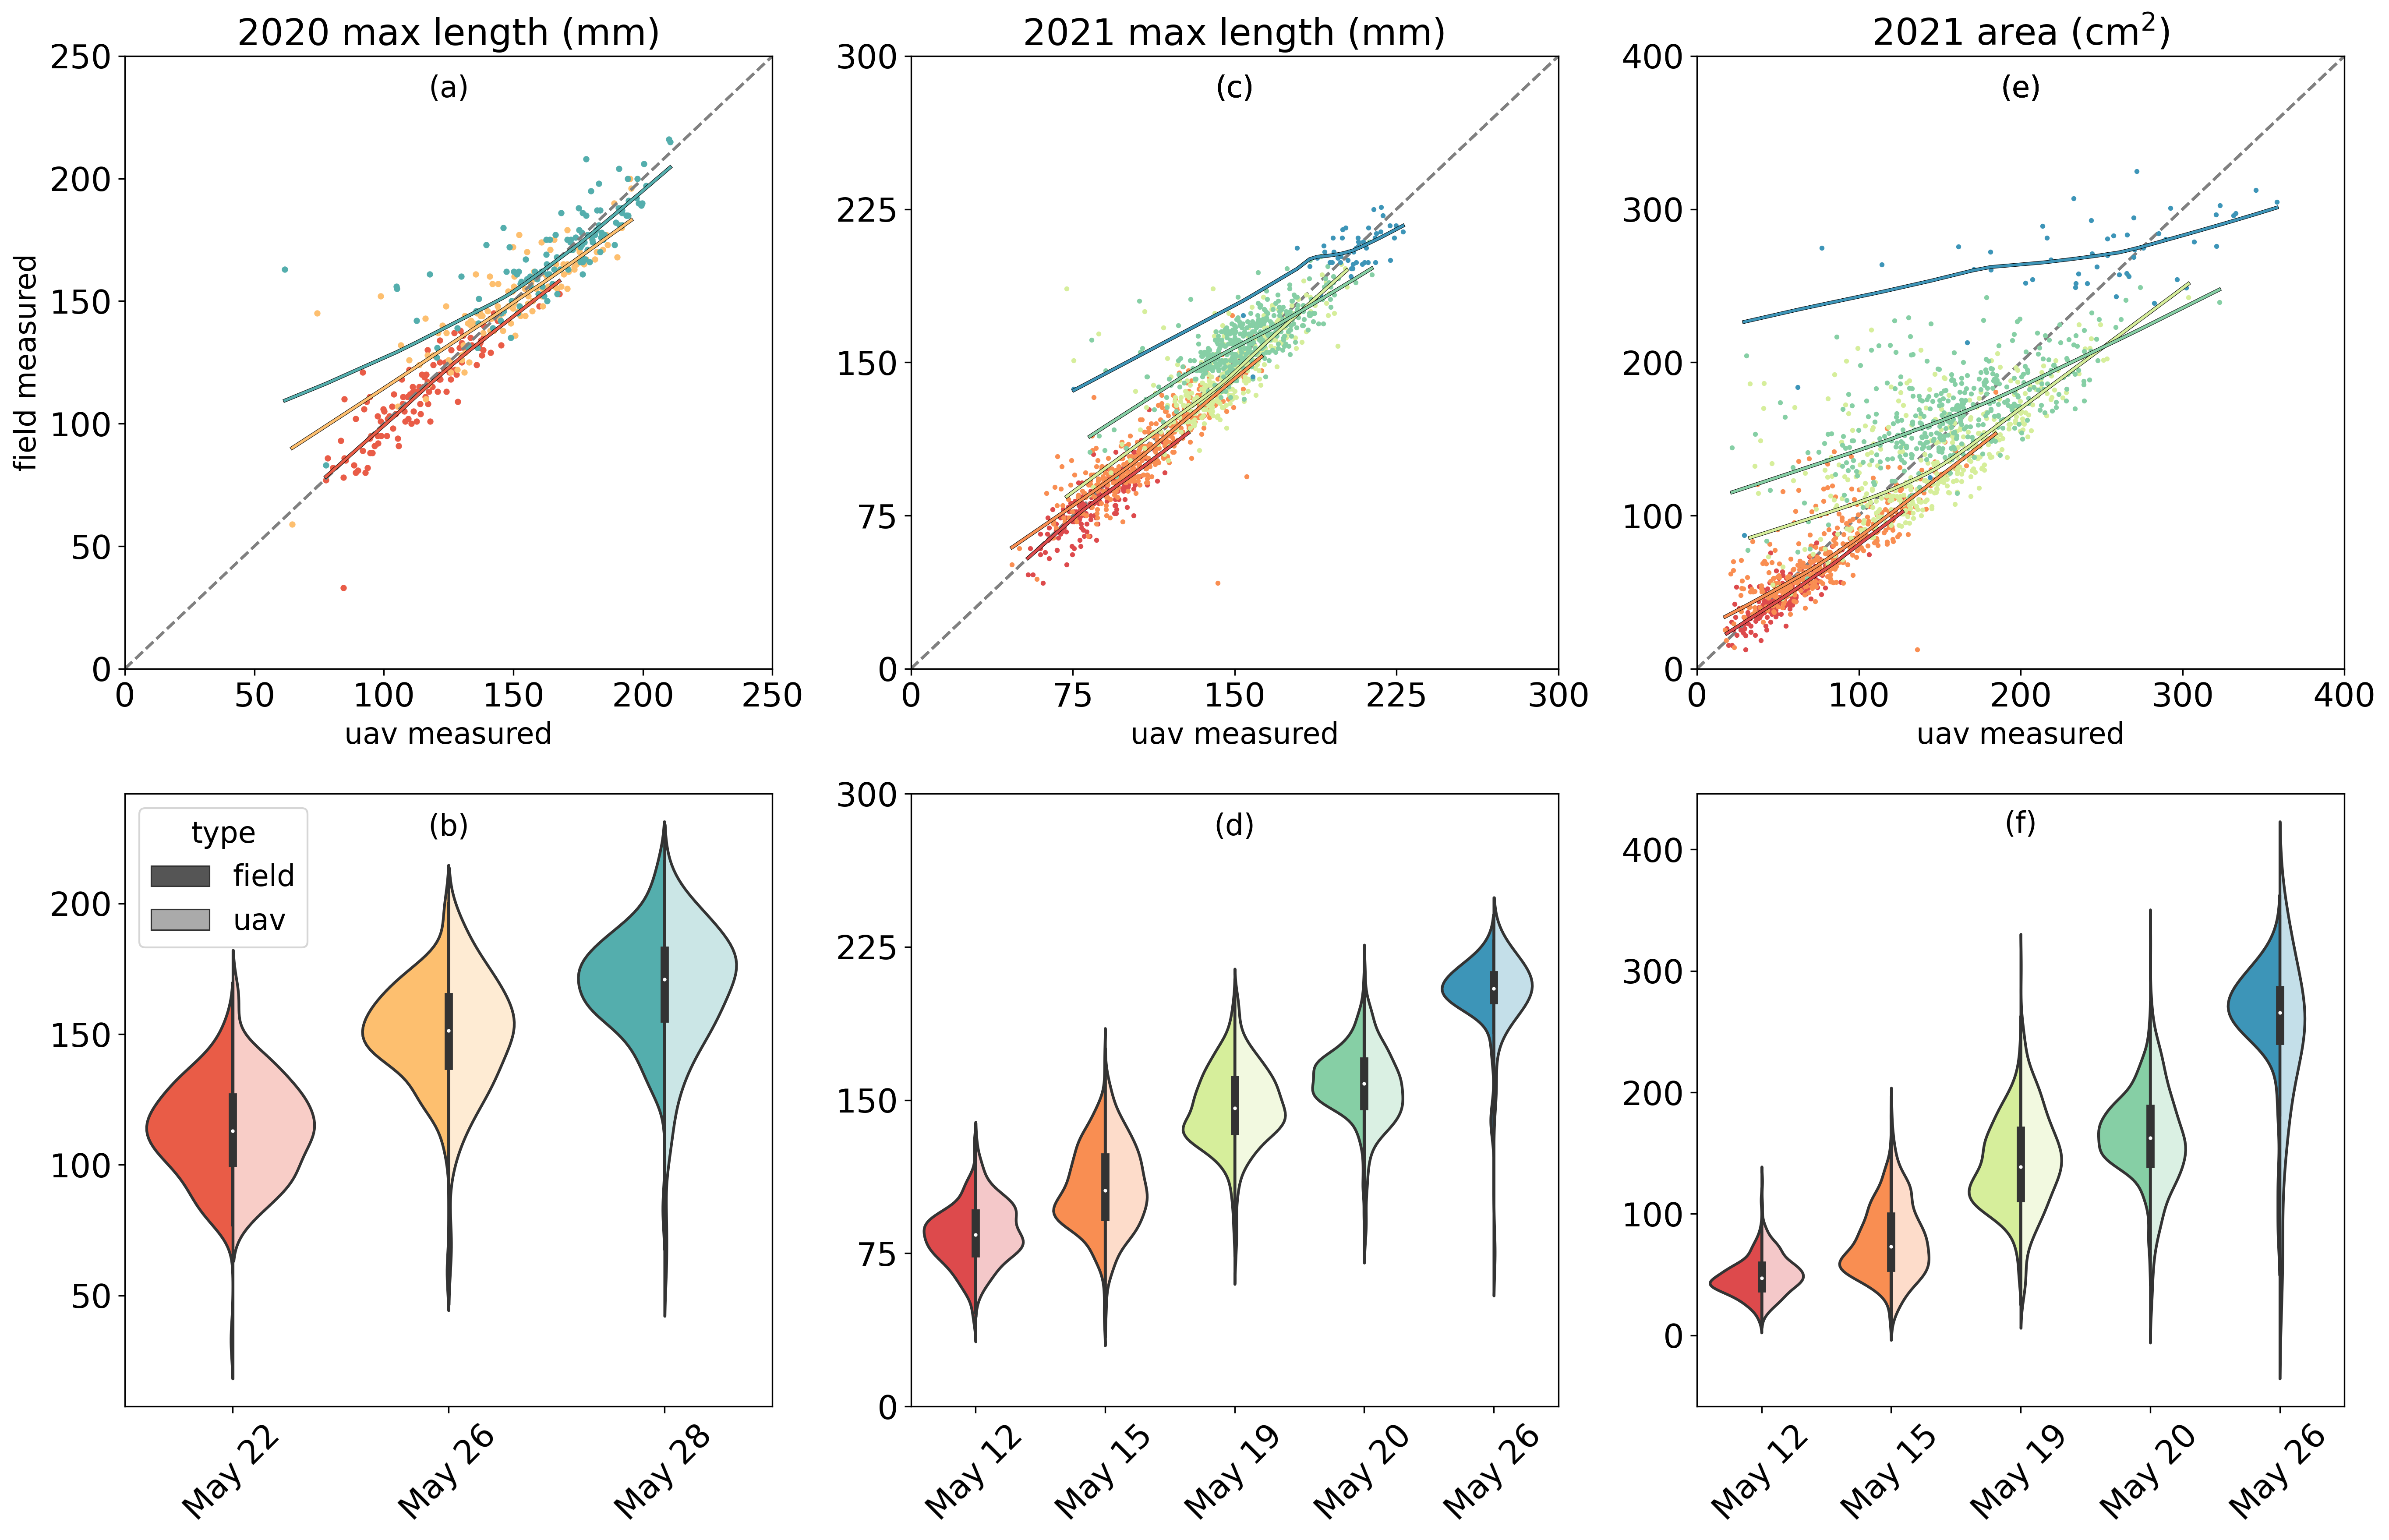

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18.46, 12), dpi=300)

#############
# plot 2020 #
#############

violin_list = []
for i, d in enumerate(match_date20):
    field = merged_pd20[merged_pd20.date == d]
    uav = merged_pd20[merged_pd20.date == d]
    
    ax[0,0].plot([0,250], [0, 250], '--', color="gray")
    ax[0,0].scatter(uav.min_area_rect_max, field.flower_size_max, color=palette20[i], marker='o', s=6)
    
    reg_x, reg_y = lowess(uav.min_area_rect_max, field.flower_size_max, 0.9)
    ax[0,0].plot(reg_x, reg_y, '-', color=palette20[i], zorder=20, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
    ax[0,0].set_xlim(0, 250)
    ax[0,0].set_ylim(0, 250)
    
    ax[0,0].set_xlabel("uav measured")
    ax[0,0].set_ylabel("field measured")
    
    fi = field.rename(columns={"flower_size_max": "max_length"})
    fi["type"] = "field"
    fi = fi[["date", "max_length", "type"]]
    
    uv = uav.rename(columns={"min_area_rect_max": "max_length"})
    uv["type"] = "uav"
    uv = uv[["date", "max_length", "type"]]
    
    data_violin = pd.concat([fi, uv])
    violin_list.append(data_violin)
    
violin_data = pd.concat(violin_list)
    
# violin plot
result_dict = sns.violinplot(x="date", y="max_length", hue="type", data=violin_data, split=True, ax=ax[1,0], palette="gray")

## change_color
collect = [item for item in result_dict.collections if isinstance(item, PolyCollection)]
for k, it in enumerate(collect):
    if k % 2 == 0: 
        color = list(palette20[k//2]) + [1]
    else:
        color = list(palette20[k//2]) + [0.3]

    it.set_facecolor(color)
    
ax[1,0].set_ylabel(None)
ax[1,0].set_xlabel(None)
ax[1,0].set_xticklabels(["May 22", "May 26", "May 28"], rotation=45)

ax[0,0].set_title("2020 max length (mm)")
ax[0,0].text(125, 250*0.97, "(a)", ha="center", va="top")

xticks = ax[1,0].get_xticks()
_, x_max = ax[1, 0].get_ylim()
ax[1,0].text(xticks[1], x_max*0.97, "(b)", ha="center", va="top")

########
# 2021 #
########

violin_list = []
for i, d in enumerate(match_date21):
    field = props_all[props_all.date == d]
    uav = merged_pd21[merged_pd21.date == d]
    
    merged = pd.merge(field, uav, on="field", suffixes=("_f","_u"))
    
    merged["area_f"] = merged["area_f"] / 100
    merged["area_u"] = merged["area_u"] / 100
    merged["min_area_rect_max_f"] = merged["min_area_rect_max_f"] * 10
    
    plot_column = ["min_area_rect_max", "area"]
    violin_column = ["date", "min_area_rect_max", "area"]
    
    subtitle = ["2021 max length", "2021 area"]
    
    lim_min = [0, 0, 0]
    lim_max = [300, 400, 1]
    unit = ["(mm)", "(cm$^2$)", "(mm)", "(mm)"]
    
    plot_rank = ["(c)", "(e)", "(d)"]
    violin_rank = ["(d)", "(f)", "(h)"]
    
    # plot 1:1 table
    for j, pc in enumerate(plot_column):
        e_x = merged[f'{pc}_u']
        e_y = merged[f'{pc}_f']
        
        ax[0, j+1].plot([lim_min[j], lim_max[j]],[lim_min[j], lim_max[j]], '--', color="gray", zorder=-1)

        ax[0, j+1].scatter(y=e_y, x=e_x, color=palette21[i], marker='o', s=3) #, alpha=merged.circularity_u)

        reg_x, reg_y = lowess(e_x, e_y, 0.9)
        #reg_x, reg_y, y_pred, t, r = linear(e_x, e_y)
        ax[0, j+1].plot(reg_x, reg_y, '-', color=palette21[i], zorder=20, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
        
        
        ax[0, j+1].set_xlim(lim_min[j], lim_max[j])
        ax[0, j+1].set_ylim(lim_min[j], lim_max[j])
        
        labels = np.linspace(lim_min[j], lim_max[j], 5).astype(np.int32)
        ax[0, j+1].set_xticks(labels)
        ax[0, j+1].set_yticks(labels)
        ax[0, j+1].set_xticklabels(labels)
        ax[0, j+1].set_yticklabels(labels)
        
        ax[0, j+1].set_xlabel("uav measured")
        
        #ax[0, j+1].set_title(f"{pc.replace('_', ' ')} {unit[j]}")
        ax[0, j+1].set_title(f"{subtitle[j]} {unit[j]}")
        ax[0, j+1].text(labels[2], lim_max[j]*0.97, plot_rank[j], ha="center", va="top")
    
    #ax[0, 0].set_ylabel("field measured")

    # plot violine table
    fi = merged[[f"{l}_f" for l in violin_column]].copy()
    fi = fi.rename(columns={f"{l}_f":l for l in violin_column})
    fi = fi.astype({l: np.float64 for l in plot_column})
    fi["type"] = "field"

    uv = merged[[f"{l}_u" for l in violin_column]].copy()
    uv = uv.rename(columns={f"{l}_u":l for l in violin_column})
    uv = uv.astype({l: np.float64 for l in plot_column})
    uv["type"] = "uav"

    data_violin = pd.concat([fi, uv])
    violin_list.append(data_violin)
    
violin_data = pd.concat(violin_list)
    
for j, pc in enumerate(plot_column):
    
    result_dict = sns.violinplot(x="date", y=pc, hue="type", data=violin_data, split=True, ax=ax[1, j+1], palette="gray")
    
    labels = np.linspace(lim_min[j], lim_max[j], 5).astype(np.int32)
    
    # CHANGE color
    collect = [item for item in result_dict.collections if isinstance(item, PolyCollection)]
    for k, it in enumerate(collect):
        if k % 2 == 0: 
            color = list(palette21[k//2]) + [1]
        else:
            color = list(palette21[k//2]) + [0.3]
   
        it.set_facecolor(color)
    
    ax[1, j+1].set_ylabel(None)
    ax[1, j+1].set_xlabel(None)
    if j != -1:
        ax[1, j+1].get_legend().remove()
    else:
        ax[1, j+1].get_legend().set_title(None)
    
    ax[1, j+1].set_xticklabels(["May 12", "May 15", "May 19","May 20", "May 26"], rotation=45)
    
    ax[1, j+1].set_yticks(labels)
    ax[1, j+1].set_yticklabels(labels)
    
    #ax[1, j+1].set_title(f"{pc.replace('_', ' ')} {unit[j]}")
    
    xticks = ax[1, j+1].get_xticks()
    _, x_max = ax[1, j+1].get_ylim()
    ax[1, j+1].text(xticks[2], x_max*0.97, violin_rank[j], ha="center", va="top")

plt.tight_layout()
plt.savefig("out/compare_merge.png")

plt.show()

# update 20220308

uav.min_area_rect_max 118, field.flower_size_max 118
y=0.903x+9.413  R^2=0.78
RMSE = 9.067849707079139
-----------------
uav.min_area_rect_max 120, field.flower_size_max 120
y=0.68x+48.936  R^2=0.7
RMSE = 10.380496269884986
-----------------
uav.min_area_rect_max 120, field.flower_size_max 120
y=0.621x+65.752  R^2=0.63
RMSE = 12.092560547755744
-----------------
e_x 187, e_y 187
y=0.837x+9.92  R^2=0.71
RMSE = 7.8700069640245225
-----------------
e_x 384, e_y 384
y=0.793x+20.336  R^2=0.72
RMSE = 10.595365271914837
-----------------
e_x 378, e_y 378
y=0.699x+42.387  R^2=0.56
RMSE = 12.397490071927363
-----------------
e_x 396, e_y 396
y=0.567x+72.413  R^2=0.6
RMSE = 9.573650486509244
-----------------
e_x 50, e_y 50
y=0.572x+87.645  R^2=0.68
RMSE = 9.090597384075622
-----------------


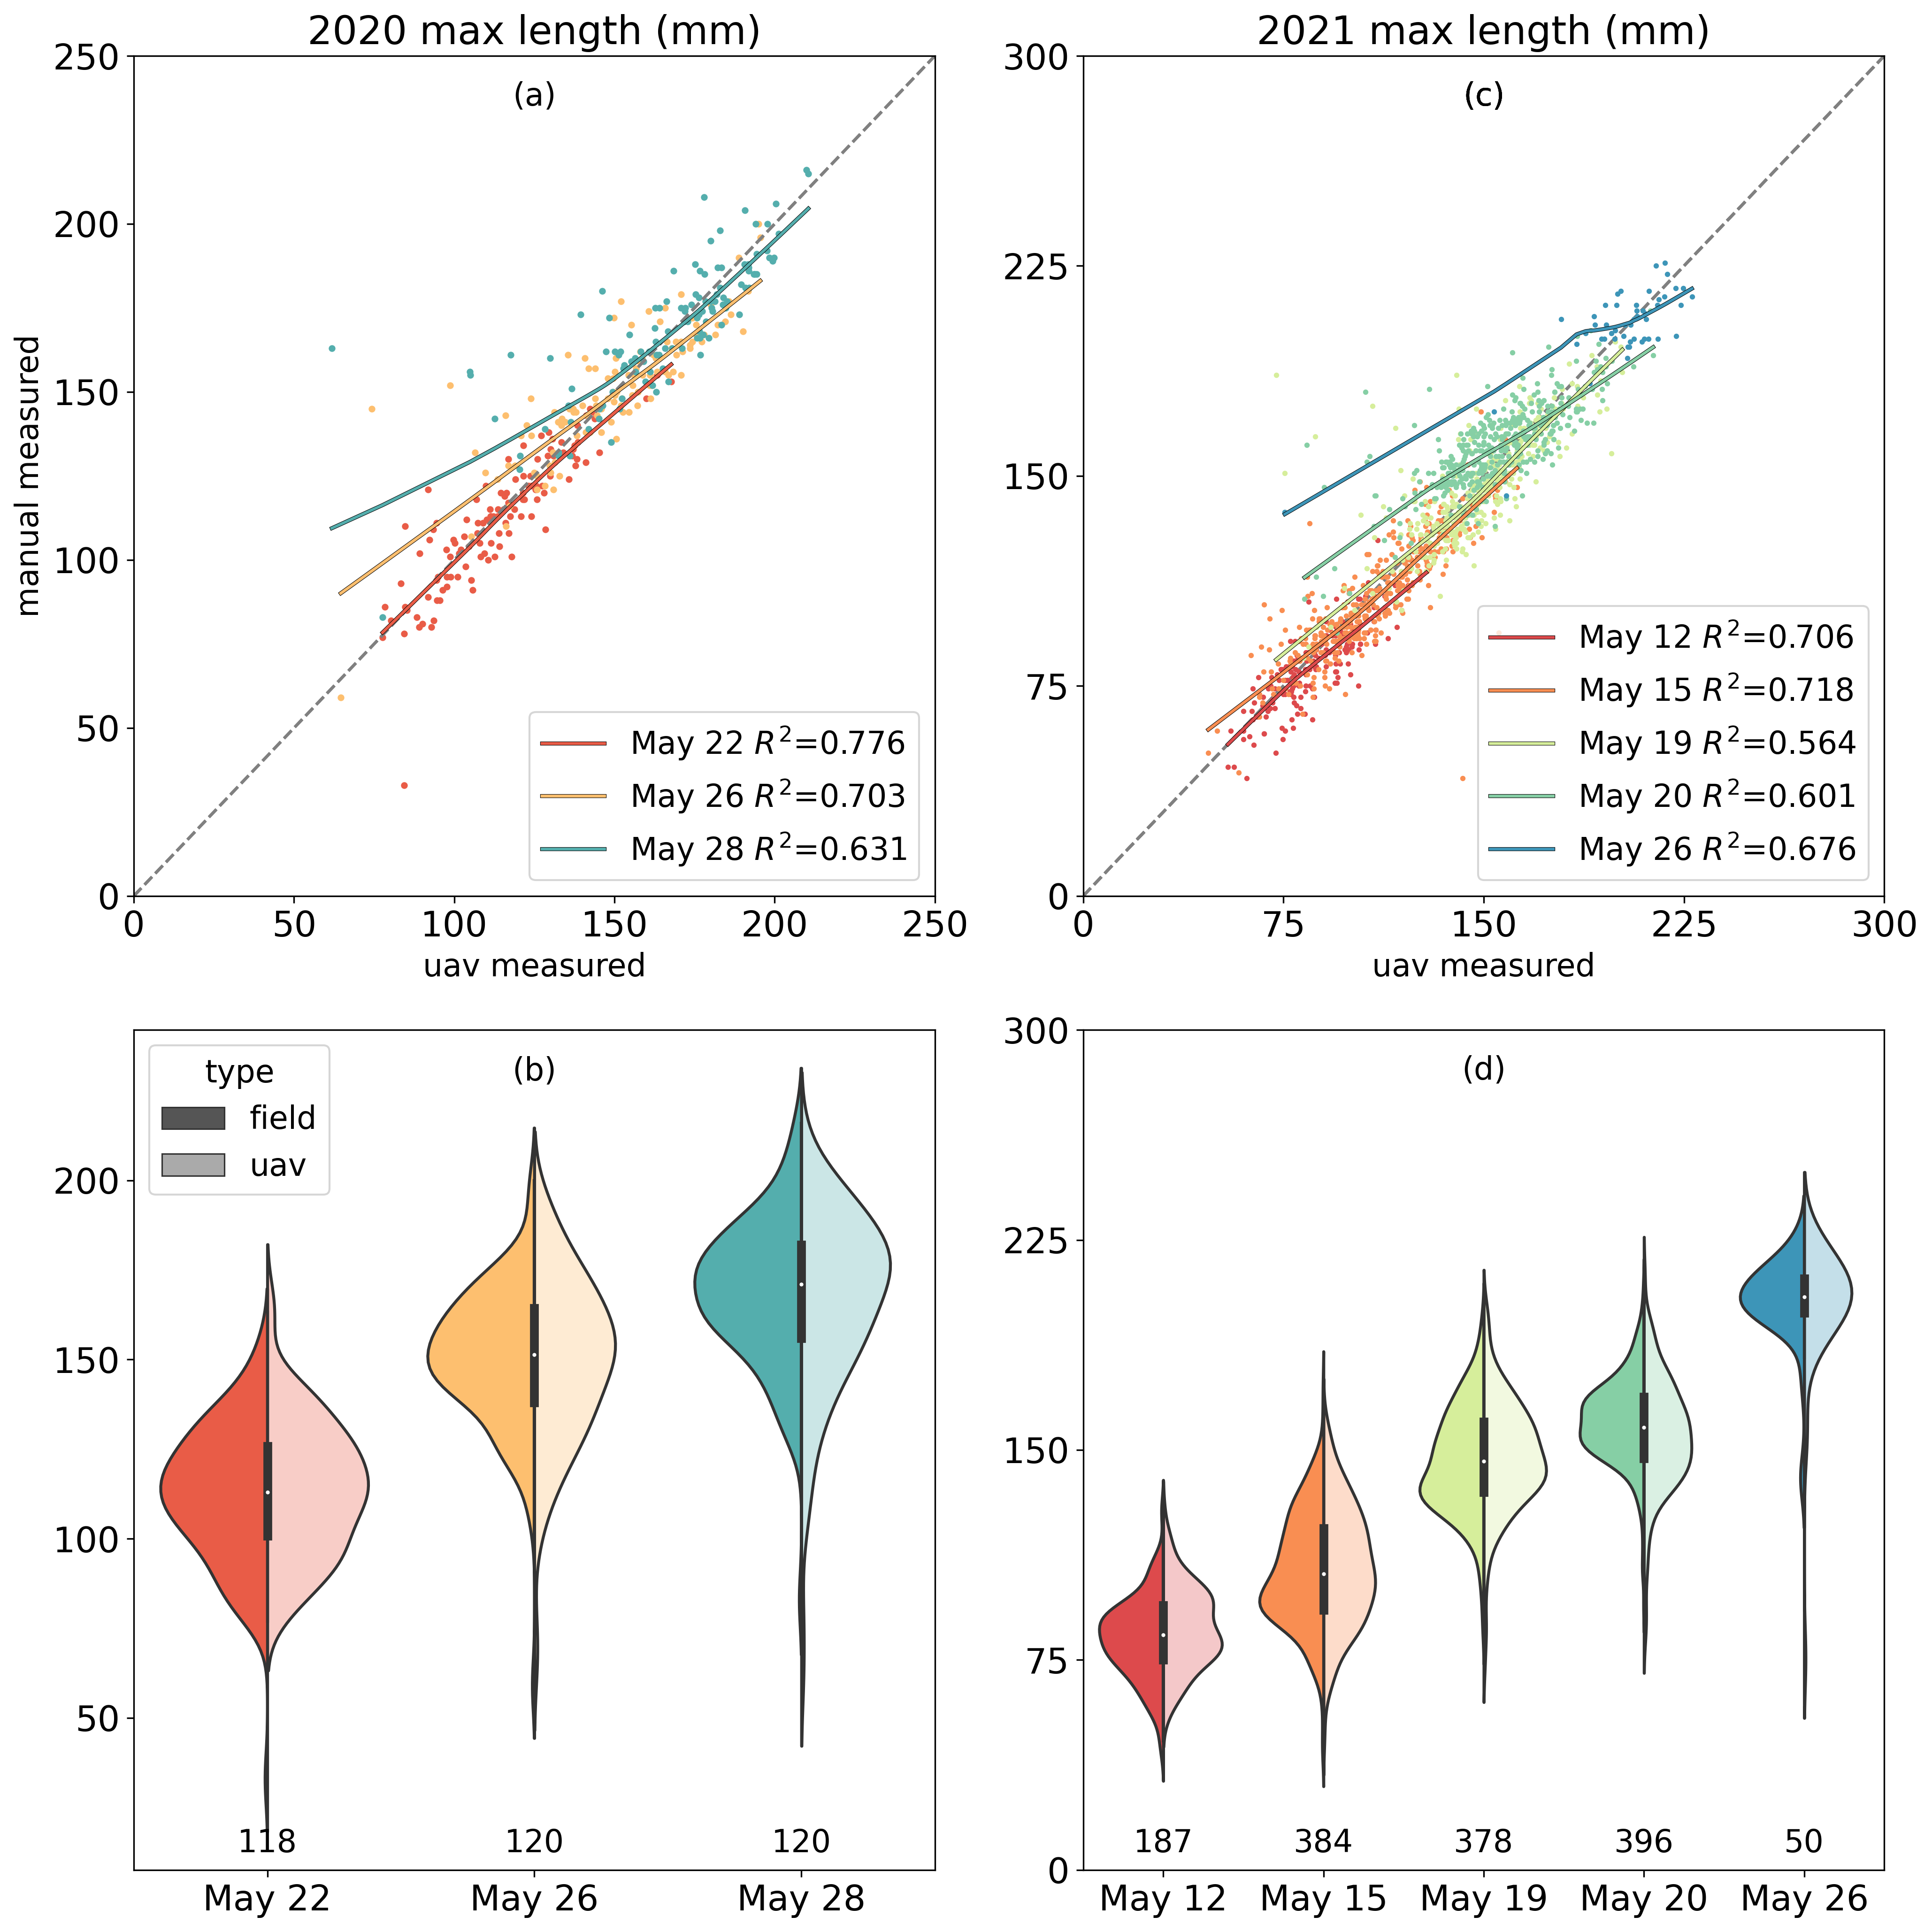

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14), dpi=300)

#############
# plot 2020 #
#############

date_list = ["May 22", "May 26", "May 28"]

num_count = []

violin_list = []
for i, d in enumerate(match_date20):
    field = merged_pd20[merged_pd20.date == d]
    uav = merged_pd20[merged_pd20.date == d]
    
    # 1:1 line
    ax[0,0].plot([0,250], [0, 250], '--', color="gray")
    ax[0,0].scatter(uav.min_area_rect_max, field.flower_size_max, color=palette20[i], marker='o', s=6)

    print(f"uav.min_area_rect_max {len(uav.min_area_rect_max)}, field.flower_size_max {len(field.flower_size_max)}")
    num_count.append(len(field.flower_size_max))
    
    reg_x, reg_y = lowess(uav.min_area_rect_max, field.flower_size_max, 0.9)
    x_points, y_points, y_predict, t, r2 = linear(uav.min_area_rect_max, field.flower_size_max, True)
    # regress line
    ax[0,0].plot(reg_x, reg_y, '-', color=palette20[i], zorder=20, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], label=f"{date_list[i]} $R^2$={round(r2, 3)}")
    ax[0,0].set_xlim(0, 250)
    ax[0,0].set_ylim(0, 250)
    
    ax[0,0].set_xlabel("uav measured")
    ax[0,0].set_ylabel("manual measured")
    
    fi = field.rename(columns={"flower_size_max": "max_length"})
    fi["type"] = "field"
    fi = fi[["date", "max_length", "type"]]
    
    uv = uav.rename(columns={"min_area_rect_max": "max_length"})
    uv["type"] = "uav"
    uv = uv[["date", "max_length", "type"]]
    
    data_violin = pd.concat([fi, uv])
    violin_list.append(data_violin)
    
violin_data = pd.concat(violin_list)
    
# violin plot
result_dict = sns.violinplot(x="date", y="max_length", hue="type", data=violin_data, split=True, ax=ax[1,0], palette="gray")

## change_color
collect = [item for item in result_dict.collections if isinstance(item, PolyCollection)]
for k, it in enumerate(collect):
    if k % 2 == 0: 
        color = list(palette20[k//2]) + [1]
    else:
        color = list(palette20[k//2]) + [0.3]

    it.set_facecolor(color)
    
ax[1,0].set_ylabel(None)
ax[1,0].set_xlabel(None)
# ax[1,0].set_xticklabels(date_list, rotation=45)
ax[1,0].set_xticklabels(date_list)

ax[0,0].set_title("2020 max length (mm)")
ax[0,0].text(125, 250*0.97, "(a)", ha="center", va="top")

ax[0,0].legend(loc="lower right")

xticks = ax[1,0].get_xticks()
_, x_max = ax[1, 0].get_ylim()
ax[1,0].text(xticks[1], x_max*0.97, "(b)", ha="center", va="top")

for kk in range(3):
    ax[1, 0].text(xticks[kk], x_max*0.08, num_count[kk], ha="center", va="top")

########
# 2021 #
########

date_list21 = ["May 12", "May 15", "May 19","May 20", "May 26"]

num_count = []

violin_list = []
for i, d in enumerate(match_date21):
    field = props_all[props_all.date == d]
    uav = merged_pd21[merged_pd21.date == d]
    
    merged = pd.merge(field, uav, on="field", suffixes=("_f","_u"))
    
    merged["area_f"] = merged["area_f"] / 100
    merged["area_u"] = merged["area_u"] / 100
    merged["min_area_rect_max_f"] = merged["min_area_rect_max_f"] * 10
    
    # plot_column = ["min_area_rect_max", "area"]
    # violin_column = ["date", "min_area_rect_max", "area"]
    # subtitle = ["2021 max length", "2021 area"]

    plot_column = ["min_area_rect_max"]
    violin_column = ["date", "min_area_rect_max"]
    subtitle = ["2021 max length"]
    
    lim_min = [0, 0, 0]
    lim_max = [300, 400, 1]
    unit = ["(mm)", "(cm$^2$)", "(mm)", "(mm)"]
    
    plot_rank = ["(c)", "(e)", "(d)"]
    violin_rank = ["(d)", "(f)", "(h)"]
    
    # plot 1:1 table
    for j, pc in enumerate(plot_column):
        e_x = merged[f'{pc}_u']
        e_y = merged[f'{pc}_f']
        
        ax[0, j+1].plot([lim_min[j], lim_max[j]],[lim_min[j], lim_max[j]], '--', color="gray", zorder=-1)

        ax[0, j+1].scatter(y=e_y, x=e_x, color=palette21[i], marker='o', s=3) #, alpha=merged.circularity_u)

        print(f"e_x {len(e_x)}, e_y {len(e_y)}")
        num_count.append(len(e_y))

        reg_x, reg_y = lowess(e_x, e_y, 0.9)
        lin_x, lin_y, y_pred_lin, t, r2 = linear(e_x, e_y)
        ax[0, j+1].plot(reg_x, reg_y, '-', color=palette21[i], zorder=20, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], label=f"{date_list21[i]} $R^2$={round(r2, 3)}")
        
        
        ax[0, j+1].set_xlim(lim_min[j], lim_max[j])
        ax[0, j+1].set_ylim(lim_min[j], lim_max[j])
        
        labels = np.linspace(lim_min[j], lim_max[j], 5).astype(np.int32)
        ax[0, j+1].set_xticks(labels)
        ax[0, j+1].set_yticks(labels)
        ax[0, j+1].set_xticklabels(labels)
        ax[0, j+1].set_yticklabels(labels)
        
        ax[0, j+1].set_xlabel("uav measured")

        ax[0, j+1].legend(loc="lower right")
        
        #ax[0, j+1].set_title(f"{pc.replace('_', ' ')} {unit[j]}")
        ax[0, j+1].set_title(f"{subtitle[j]} {unit[j]}")
        ax[0, j+1].text(labels[2], lim_max[j]*0.97, plot_rank[j], ha="center", va="top")
    
    #ax[0, 0].set_ylabel("field measured")

    # plot violine table
    fi = merged[[f"{l}_f" for l in violin_column]].copy()
    fi = fi.rename(columns={f"{l}_f":l for l in violin_column})
    fi = fi.astype({l: np.float64 for l in plot_column})
    fi["type"] = "field"

    uv = merged[[f"{l}_u" for l in violin_column]].copy()
    uv = uv.rename(columns={f"{l}_u":l for l in violin_column})
    uv = uv.astype({l: np.float64 for l in plot_column})
    uv["type"] = "uav"

    data_violin = pd.concat([fi, uv])
    violin_list.append(data_violin)
    
violin_data = pd.concat(violin_list)
    
for j, pc in enumerate(plot_column):
    
    result_dict = sns.violinplot(x="date", y=pc, hue="type", data=violin_data, split=True, ax=ax[1, j+1], palette="gray")
    
    labels = np.linspace(lim_min[j], lim_max[j], 5).astype(np.int32)
    
    # CHANGE color
    collect = [item for item in result_dict.collections if isinstance(item, PolyCollection)]
    for k, it in enumerate(collect):
        if k % 2 == 0: 
            color = list(palette21[k//2]) + [1]
        else:
            color = list(palette21[k//2]) + [0.3]
   
        it.set_facecolor(color)
    
    ax[1, j+1].set_ylabel(None)
    ax[1, j+1].set_xlabel(None)
    if j != -1:
        ax[1, j+1].get_legend().remove()
    else:
        ax[1, j+1].get_legend().set_title(None)
    
    # ax[1, j+1].set_xticklabels(date_list21, rotation=45)
    ax[1, j+1].set_xticklabels(date_list21)
    
    ax[1, j+1].set_yticks(labels)
    ax[1, j+1].set_yticklabels(labels)
    
    #ax[1, j+1].set_title(f"{pc.replace('_', ' ')} {unit[j]}")
    
    xticks = ax[1, j+1].get_xticks()
    _, x_max = ax[1, j+1].get_ylim()
    ax[1, j+1].text(xticks[2], x_max*0.97, violin_rank[j], ha="center", va="top")

    for kk in range(5):
        ax[1, j+1].text(xticks[kk], x_max*0.05, num_count[kk], ha="center", va="top")

plt.tight_layout()
plt.savefig("out/compare_merge_220308.png")

plt.show()